In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    make_ohlc,
    FeatureEngineering
)

import plotly.graph_objects as go

In [2]:
x_c, y_c = stationary_dgp()
y_o, y_h, y_l, _ = make_ohlc(y_c)
x_o, x_h, x_l, _ = make_ohlc(x_c)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
fig = go.Figure(data=[go.Candlestick(x=df.index, open=x_o, high=x_h, low=x_l, close=x_c)])
fig.update_layout(title='Candlestick Char of X', xaxis_title='Day interval', yaxis_title='Price')
fig.show()

In [4]:
fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'])])
fig.update_layout(title='Candlestick Chart of Y - X', xaxis_title='Day interval', yaxis_title='Price')
fig.show()

In [5]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.489e+05
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:02:34   Log-Likelihood:                 316.87
No. Observations:               10000   AIC:                            -629.7
Df Residuals:                    9998   BIC:                            -615.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0003      0.027   3716.112      0.0

In [6]:
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -21.249996626086574
p-value: 0.0
Is the spread stationary? Yes


In [11]:
feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'logdiff',
       'subtract_mean': False
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)

In [13]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return : -0.02%   |   Portfolio Return : -64.85%   |   Position Changes : 6633   |   Episode Length : 10000   |   


In [14]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.02%   |   Portfolio Return : -32.14%   |   Position Changes : 3939   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return :  9.98%   |   Position Changes : 2254   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 38.23%   |   Position Changes : 2374   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 33.80%   |   Position Changes : 2409   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 37.94%   |   Position Changes : 2372   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 32.51%   |   Position Changes : 2454   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 34.79%   |   Position Changes : 2485   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Portfolio Return : 35.09%   |   Position Changes : 2441   |   Episode Length : 10000   |   
Market Return : -0.02%   |   Po

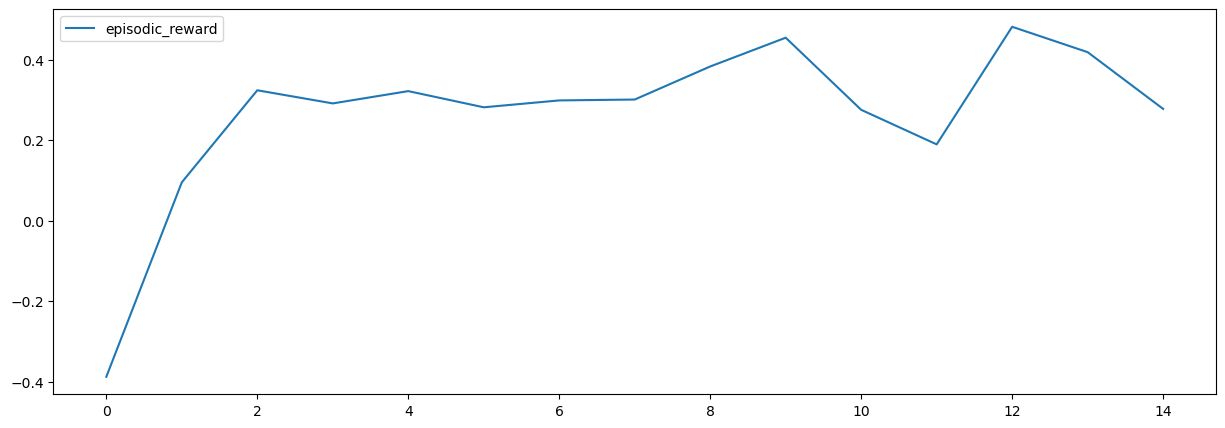

In [15]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [16]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp()
    y_o, y_h, y_l, _ = make_ohlc(y_c)
    x_o, x_h, x_l, _ = make_ohlc(x_c)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            # dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.00%   |   Portfolio Return : 79.12%   |   Position Changes : 1691   |   Episode Length : 10000   |   
Market Return :  0.07%   |   Portfolio Return : 69.38%   |   Position Changes : 1687   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 58.64%   |   Position Changes : 1683   |   Episode Length : 10000   |   
Market Return : -0.43%   |   Portfolio Return : 73.65%   |   Position Changes : 1694   |   Episode Length : 10000   |   
Market Return : -0.14%   |   Portfolio Return : 74.95%   |   Position Changes : 1654   |   Episode Length : 10000   |   
Market Return :  0.20%   |   Portfolio Return : 79.35%   |   Position Changes : 1657   |   Episode Length : 10000   |   
Market Return :  0.26%   |   Portfolio Return : 65.57%   |   Position Changes : 1686   |   Episode Length : 10000   |   
Market Return : -0.16%   |   Portfolio Return : 61.67%   |   Position Changes : 1693   |   Episode Length : 10000   |   
Market Return :  0.17%   |   Por

In [20]:
history = [env_test.unwrapped.historical_info[i] for i in range(len(env_test.unwrapped.historical_info))]
historical_info_df = pd.DataFrame(history)
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_close', 'data_volume', 'data_low', 'data_high', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

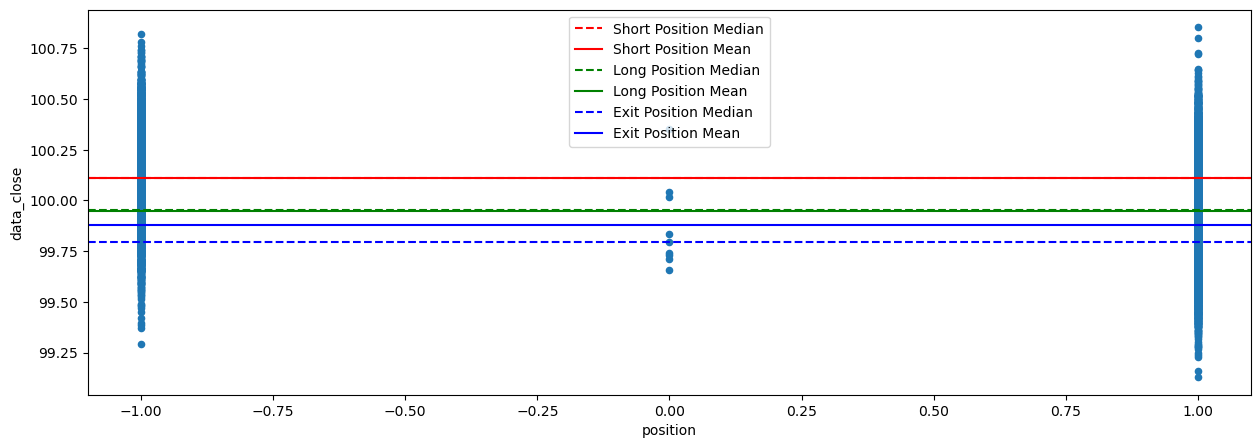

In [22]:
ax = historical_info_df.plot(x="position", y="data_close", kind="scatter", figsize=(15, 5))
short_pos_median = historical_info_df.loc[historical_info_df["position"] == -1, "data_close"].median()
short_pos_mean = historical_info_df.loc[historical_info_df["position"] == -1, "data_close"].mean()
long_pos_median = historical_info_df.loc[historical_info_df["position"] == 1, "data_close"].median()
long_pos_mean = historical_info_df.loc[historical_info_df["position"] == 1, "data_close"].mean()
exit_pos_median = historical_info_df.loc[historical_info_df["position"] == 0, "data_close"].median()
exit_pos_mean = historical_info_df.loc[historical_info_df["position"] == 0, "data_close"].mean()

ax.axhline(short_pos_median, color="red", linestyle="--", label="Short Position Median")
ax.axhline(short_pos_mean, color="red", linestyle="-", label="Short Position Mean")
ax.axhline(long_pos_median, color="green", linestyle="--", label="Long Position Median")
ax.axhline(long_pos_mean, color="green", linestyle="-", label="Long Position Mean")
ax.axhline(exit_pos_median, color="blue", linestyle="--", label="Exit Position Median")
ax.axhline(exit_pos_mean, color="blue", linestyle="-", label="Exit Position Mean")
ax.legend()

In [17]:
env_test.unwrapped.save_for_render(dir = "render_logs")

In [17]:
# build features
df_train = df.copy()

feature_config = [
    # {'type': 'rolling',
    #  'params': {
    #    'cols': ['close'],
    #    'window': 7,
    #    'mode': 'diff',
    #    'subtract_mean': False
    #  }},
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,99.741563,100.808228,98.674898,99.741563,99.741563
2020-01-02,99.668825,100.608064,98.821856,99.761095,99.761095
2020-01-03,99.382273,101.592195,97.573809,99.783732,99.783732
2020-01-04,99.638806,100.428852,99.094300,99.884347,99.884347
2020-01-05,99.820865,102.334879,97.518174,100.032187,100.032187
...,...,...,...,...,...
2047-05-14,100.004447,100.421299,99.757084,100.173937,100.173937
2047-05-15,100.062113,101.533999,98.870049,100.341935,100.341935
2047-05-16,100.530774,102.458253,98.508523,100.436002,100.436002
2047-05-17,100.728878,101.171545,99.861869,100.304535,100.304535


In [18]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[99.74156  0.       0.     ]
Market Return :  0.56%   |   Portfolio Return : -0.57%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [19]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.56%   |   Portfolio Return : -64.62%   |   Position Changes : 6727   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : -60.97%   |   Position Changes : 6672   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return :  2.40%   |   Position Changes : 5816   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : -3.72%   |   Position Changes : 5895   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : 127.57%   |   Position Changes : 4301   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : 117.49%   |   Position Changes : 4414   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : 216.31%   |   Position Changes : 3553   |   Episode Length : 10000   |   
Market Return :  0.56%   |   Portfolio Return : 202.21%   |   Position Changes : 3531   |   Episode Length : 10000   |   
Market Return :  0.56%   |

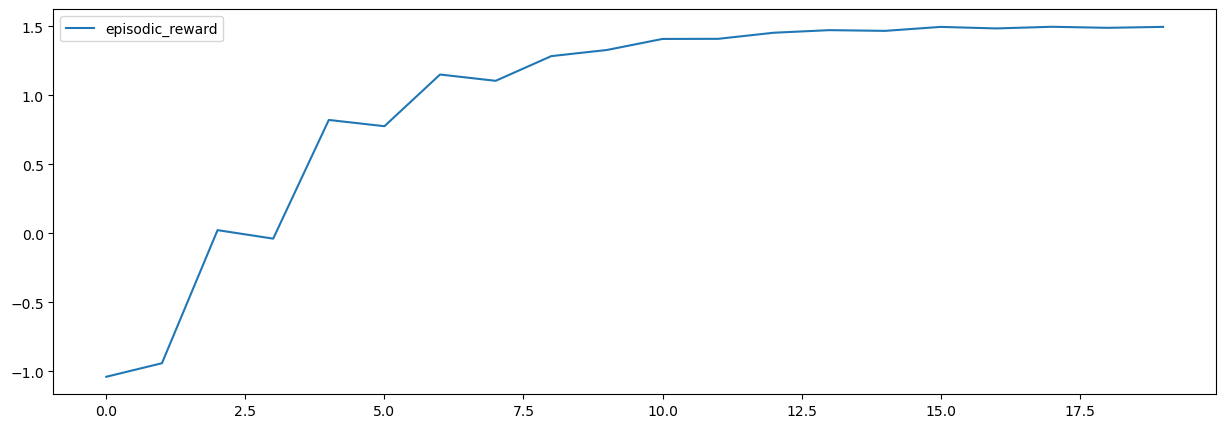

In [20]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [21]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp()
    y_o, y_h, y_l, _ = make_ohlc(y_c)
    x_o, x_h, x_l, _ = make_ohlc(x_c)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -0.39%   |   Portfolio Return : 282.62%   |   Position Changes : 2227   |   Episode Length : 10000   |   
Market Return : -0.40%   |   Portfolio Return : 327.80%   |   Position Changes : 2374   |   Episode Length : 10000   |   
Market Return :  0.17%   |   Portfolio Return : 320.97%   |   Position Changes : 2380   |   Episode Length : 10000   |   
Market Return :  0.10%   |   Portfolio Return : 345.59%   |   Position Changes : 2416   |   Episode Length : 10000   |   
Market Return : -0.18%   |   Portfolio Return : 319.58%   |   Position Changes : 2329   |   Episode Length : 10000   |   
Market Return :  0.24%   |   Portfolio Return : 334.77%   |   Position Changes : 2379   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 294.44%   |   Position Changes : 2299   |   Episode Length : 10000   |   
Market Return : -0.01%   |   Portfolio Return : 335.06%   |   Position Changes : 2437   |   Episode Length : 10000   |   
Market Return : -0.51%  

In [22]:
env_test.unwrapped.save_for_render(dir = "render_logs")

In [23]:
history = [env_test.unwrapped.historical_info[i] for i in range(len(env_test.unwrapped.historical_info))]
df_historical_info = pd.DataFrame(history)
df_historical_info.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_close', 'data_low', 'data_volume', 'data_high', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

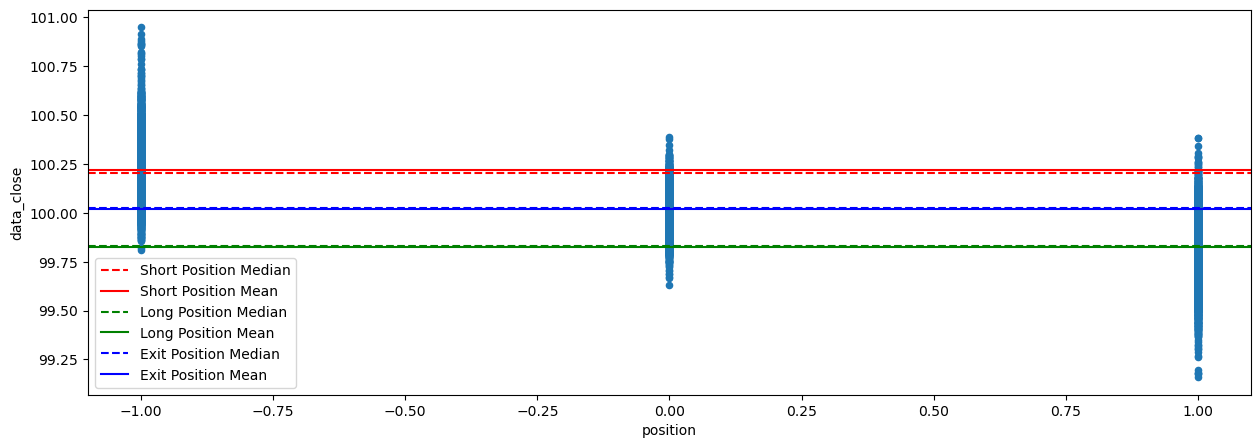

In [27]:
ax = df_historical_info.plot(x="position", y="data_close", kind="scatter", figsize=(15, 5))
short_pos_median = df_historical_info.loc[df_historical_info["position"] == -1, "data_close"].median()
short_pos_mean = df_historical_info.loc[df_historical_info["position"] == -1, "data_close"].mean()
long_pos_median = df_historical_info.loc[df_historical_info["position"] == 1, "data_close"].median()
long_pos_mean = df_historical_info.loc[df_historical_info["position"] == 1, "data_close"].mean()
exit_pos_median = df_historical_info.loc[df_historical_info["position"] == 0, "data_close"].median()
exit_pos_mean = df_historical_info.loc[df_historical_info["position"] == 0, "data_close"].mean()

ax.axhline(short_pos_median, color="red", linestyle="--", label="Short Position Median")
ax.axhline(short_pos_mean, color="red", linestyle="-", label="Short Position Mean")
ax.axhline(long_pos_median, color="green", linestyle="--", label="Long Position Median")
ax.axhline(long_pos_mean, color="green", linestyle="-", label="Long Position Mean")
ax.axhline(exit_pos_median, color="blue", linestyle="--", label="Exit Position Median")
ax.axhline(exit_pos_mean, color="blue", linestyle="-", label="Exit Position Mean")
ax.legend()